## Great barrier rief

kaggle great-barrier-reef: https://www.kaggle.com/c/tensorflow-great-barrier-reef/code?competitionId=31703&searchQuery=yolo (use this for yolo implementation)

Kaggle ship detection: https://www.kaggle.com/c/airbus-ship-detection/code?competitionId=9988&searchQuery=yolo (use this for unet impelementation)

## Import Libraries

In [8]:
import os
import sys
import wandb
import torch
import time
import random
import shutil
import yaml
from tqdm import tqdm
import warnings
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from IPython.display import display_html

In [2]:
## read files containg anchors, classes

In [9]:
# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'greatReef', '_wandb_kernel': 'aot'}

In [12]:
wandb.login()

wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ········


True

In [13]:
wandb.init(project="kaggle_barrier_reif",
           config={'competition': 'greatReef', '_wandb_kernel': 'aot'})


In [14]:
# Custom colors
class color:
    S = '\033[1m' + '\033[94m'
    E = '\033[0m'

Current Directory /Users/nehapawar/Desktop/neha/Contests
Notebook Color Scheme:


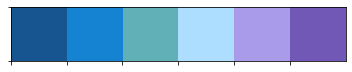

In [15]:
my_colors = ["#16558F", "#1583D2", "#61B0B7", "#ADDEFF", "#A99AEA", "#7158B7"]
print(color.S+"Current Directory"+color.E, os.getcwd())
print(color.S+"Notebook Color Scheme:"+color.E)
sns.palplot(sns.color_palette(my_colors))

## Helper function for wandb

In [16]:
def save_dataset_artifact(run_name, artifact_name, path):
    '''Saves dataset to W&B Artifactory.
    run_name: name of the experiment
    artifact_name: under what name should the dataset be stored
    path: path to the dataset'''
    
    run = wandb.init(project='g2net', 
                     name=run_name, 
                     config=CONFIG, anonymous="allow")
    artifact = wandb.Artifact(name=artifact_name, 
                              type='dataset')
    artifact.add_file(path)

    wandb.log_artifact(artifact)
    wandb.finish()
    print("Artifact has been saved successfully.")

In [17]:
def create_wandb_plot(x_data=None, y_data=None, x_name=None, y_name=None, title=None, log=None, plot="line"):
    '''Create and save lineplot/barplot in W&B Environment.
    x_data & y_data: Pandas Series containing x & y data
    x_name & y_name: strings containing axis names
    title: title of the graph
    log: string containing name of log'''
    
    data = [[label, val] for (label, val) in zip(x_data, y_data)]
    table = wandb.Table(data=data, columns = [x_name, y_name])
    
    if plot == "line":
        wandb.log({log : wandb.plot.line(table, x_name, y_name, title=title)})
    elif plot == "bar":
        wandb.log({log : wandb.plot.bar(table, x_name, y_name, title=title)})
    elif plot == "scatter":
        wandb.log({log : wandb.plot.scatter(table, x_name, y_name, title=title)})
        

In [18]:
def create_wandb_hist(x_data=None, x_name=None, title=None, log=None):
    '''Create and save histogram in W&B Environment.
    x_data: Pandas Series containing x values
    x_name: strings containing axis name
    title: title of the graph
    log: string containing name of log'''
    
    data = [[x] for x in x_data]
    table = wandb.Table(data=data, columns=[x_name])
    wandb.log({log : wandb.plot.histogram(table, x_name, title=title)})

## Data Prepration

Create two folders:
    1. images - empty folder where we will store our training images
    2. labels - empty folder where we will store out labels (or annotations) found within these images

In [22]:
# Import the prepped train dataset
train = pd.read_csv("../data/tensorflow-great-barrier-reef/output/train.csv")

# Remove all images that have no bounding box (removing ~80% of data)
train = train[train["no_annotations"]>0].reset_index(drop=True)

train.sample(3, random_state=24)

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,no_annotations,path,f_annotations,path_images,path_labels,width,height,coco_bbox
3825,1,60754,9037,621,1-9037,"[{'x': 424, 'y': 284, 'width': 44, 'height': 33}]",1,../input/tensorflow-great-barrier-reef/train_i...,"[[424, 284, 468, 317]]",/kaggle/images/video_1_9037.jpg,/kaggle/labels/video_1_9037.txt,1280,720,"[[424, 284, 44, 33]]"
2368,1,8503,3925,97,1-3925,"[{'x': 61, 'y': 254, 'width': 67, 'height': 44...",4,../input/tensorflow-great-barrier-reef/train_i...,"[[61, 254, 128, 298], [2, 311, 75, 361], [24, ...",/kaggle/images/video_1_3925.jpg,/kaggle/labels/video_1_3925.txt,1280,720,"[[61, 254, 67, 44], [2, 311, 73, 50], [24, 290..."
178,0,40258,246,246,0-246,"[{'x': 881, 'y': 259, 'width': 28, 'height': 25}]",1,../input/tensorflow-great-barrier-reef/train_i...,"[[881, 259, 909, 284]]",/kaggle/images/video_0_246.jpg,/kaggle/labels/video_0_246.txt,1280,720,"[[881, 259, 28, 25]]"
